<a href="https://colab.research.google.com/github/danikagupta/DeepTextile/blob/main/NIRS_inter_intra_class_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 4.5 MB/s eta 0:00:00

=== Processing class: Cotton ===


/tmp/ipython-input-3144259664.py:102: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)



=== Processing class: Polyester ===


/tmp/ipython-input-3144259664.py:102: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)



=== Processing class: Nylon ===


/tmp/ipython-input-3144259664.py:102: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)



=== Processing class: Cotton–Poly Blend ===


/tmp/ipython-input-3144259664.py:102: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)



=== Processing class: Poly–Spandex Blend ===


/tmp/ipython-input-3144259664.py:102: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)



Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/intra_class_distances.csv
         Fabric Class  Intra Cosine Mean  Intra Cosine SD  \
0              Cotton           0.002471         0.002810   
3   Cotton–Poly Blend           0.002143         0.002426   
2               Nylon           0.002408         0.003270   
1           Polyester           0.003542         0.003585   
4  Poly–Spandex Blend           0.003940         0.004072   

   Intra Euclidean Mean  Intra Euclidean SD  
0              3.538913            4.264320  
3              2.930247            3.511552  
2              2.302734            2.439090  
1              4.661076            4.581439  
4              5.770990            5.242610  
Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/inter_cosine_classmean.csv
Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/inter_cosine_allpatch.csv
Saved: /content/drive/Shared

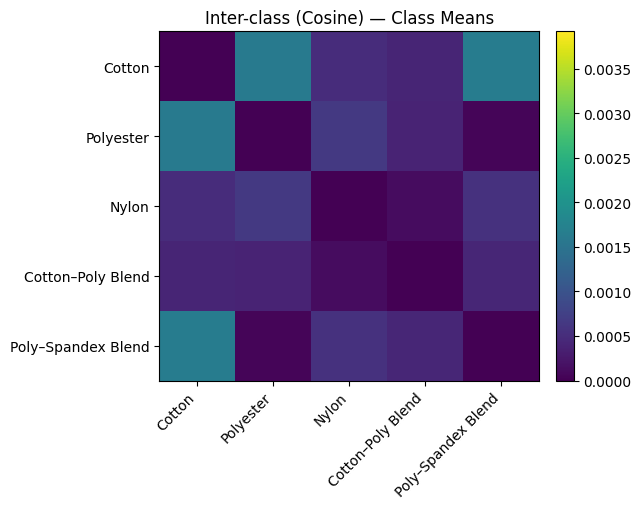

Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/heat_inter_cosine_mean.png


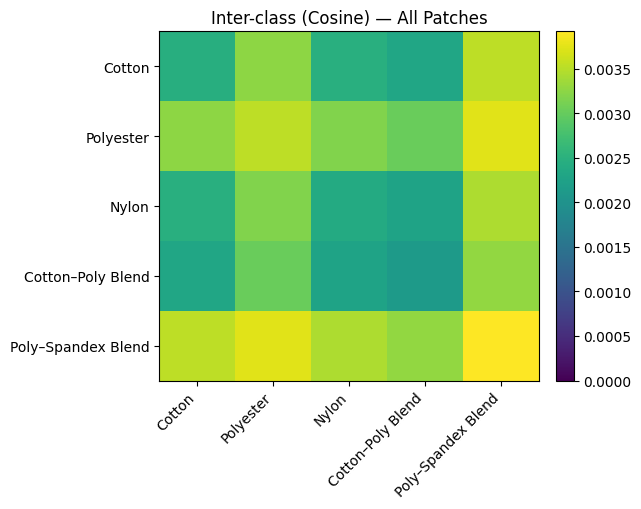

Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/heat_inter_cosine_all.png


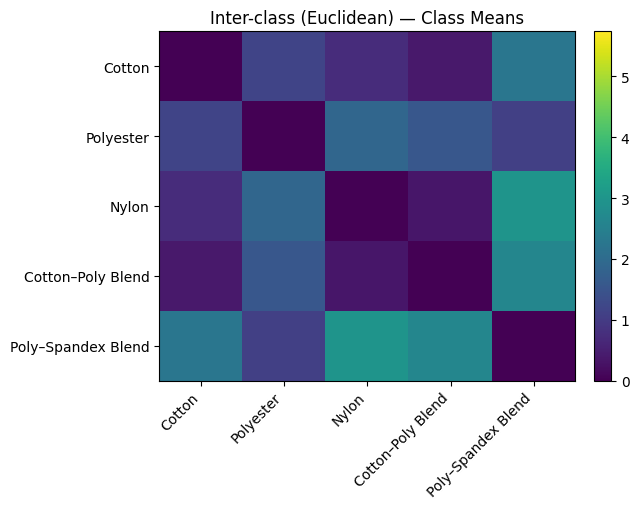

Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/heat_inter_euclidean_mean.png


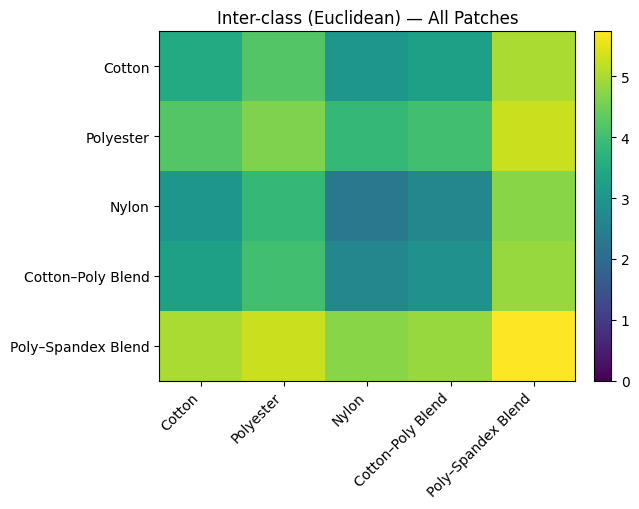

Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/heat_inter_euclidean_all.png

Saved: /content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis/intra_inter_summary.csv
         Fabric Class  Intra Cosine Mean  Inter Cosine Mean (to others)  \
0              Cotton           0.002471                       0.001038   
3   Cotton–Poly Blend           0.002143                       0.000341   
2               Nylon           0.002408                       0.000460   
1           Polyester           0.003542                       0.000675   
4  Poly–Spandex Blend           0.003940                       0.000670   

   Intra Euclidean Mean  Inter Euclidean Mean (to others)  
0              3.538913                          1.137277  
3              2.930247                          1.230960  
2              2.302734                          1.483569  
1              4.661076                          1.421791  
4              5.770990      

In [2]:
# ============================================
# Colab: Intra-class vs Inter-class Variability
# (pairwise spectral distances; cosine & Euclidean)
# ============================================

!pip -q install spectral numpy matplotlib pandas scikit-learn

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral as spy
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

# Optional: reduce ENVI capitalization warnings
import spectral
spectral.settings.envi_support_nonlowercase_params = True

plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['savefig.dpi'] = 300

# ---------- CONFIG (EDIT THESE) ----------
OUTDIR = "/content/drive/Shareddrives/Danika-work4/Textile/inter-intra-class-analysis"

# Map each class to its ENVI paths
# Replace the dummy paths with your actual files.
CLASSES = {
    "Cotton": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Cotton/capture/Joann_Fab_100Cotton.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Cotton/capture/WHITEREF_Joann_Fab_100Cotton.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Cotton/capture/DARKREF_Joann_Fab_100Cotton.hdr",
    },
    "Polyester": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_0002/capture/Joann_Fab_100Poly_0002.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_0002/capture/WHITEREF_Joann_Fab_100Poly_0002.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_0002/capture/DARKREF_Joann_Fab_100Poly_0002.hdr",
    },
    "Nylon": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Nylon/capture/Joann_Nylon.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Nylon/capture/WHITEREF_Joann_Nylon.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Nylon/capture/DARKREF_Joann_Nylon.hdr",
    },
    "Cotton–Poly Blend": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_CottonBlend/capture/Joann_Fab_100Poly_CottonBlend.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_CottonBlend/capture/WHITEREF_Joann_Fab_100Poly_CottonBlend.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Fab_100Poly_CottonBlend/capture/DARKREF_Joann_Fab_100Poly_CottonBlend.hdr",
    },
    "Poly–Spandex Blend": {
        "sample_hdr": "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Poly_Spand/capture/Joann_Poly_Spand.hdr",
        "white_hdr":  "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Poly_Spand/capture/WHITEREF_Joann_Poly_Spand.hdr",
        "dark_hdr":   "/content/drive/Shareddrives/Danika_Gupta_Work/Research/TextileRecycle/SPECIM_Data/Joann_Poly_Spand/capture/DARKREF_Joann_Poly_Spand.hdr",
    },
}



# Layout of the 3 swatches: "auto" chooses 'row' if rows >= 3 else 'col'
LAYOUT_AXIS = "auto"   # "auto" | "row" | "col"

# Trim noisy edge bands (set to None to disable)
TRIM_BANDS = (5, -5)

# Patch sampling (sampler will auto-shrink to fit swatch if needed)
PATCH_SIZE_RC      = (30, 30)   # (rows, cols)
PATCHES_PER_SWATCH = 60
RANDOM_SEED        = 123

# Distance configuration
USE_COSINE     = True   # cosine distance in [0, 2]
USE_EUCLIDEAN  = True   # Euclidean distance
# ---------- END CONFIG ----------


# ----------------- Helpers -----------------
def open_envi(hdr_path):
    img = spy.open_image(hdr_path)
    cube = img.load()
    if cube.ndim != 3:
        raise ValueError(f"Expected 3D cube, got {cube.shape} @ {hdr_path}")
    return img, cube

def apply_trim(arr, trim):
    if trim is None or arr is None:
        return arr
    s, e = trim
    if isinstance(arr, (list, tuple)):
        arr = np.array(arr)
    if isinstance(arr, np.ndarray):
        if arr.ndim == 1:
            return arr[s: (None if e == 0 else e)]
        elif arr.ndim == 3:
            return arr[..., s: (None if e == 0 else e)]
    return arr

def ref_vector_from_cube(ref_cube):
    return np.asarray(ref_cube.mean(axis=(0,1)))

def calibrate_cube(S_cube, W_vec, D_vec, eps=1e-6):
    Wv = W_vec.reshape((1,1,-1))
    Dv = D_vec.reshape((1,1,-1))
    Rc = (S_cube - Dv) / (Wv - Dv + eps)
    return np.clip(Rc, 0.0, 1.0)

def rowcol_profile(S_cube, axis='row'):
    return S_cube.mean(axis=(1,2)) if axis=='row' else S_cube.mean(axis=(0,2))

def contiguous_runs_from_labels(labels):
    segs, start, cur = [], 0, labels[0]
    for i in range(1, len(labels)):
        if labels[i] != cur:
            segs.append((start, i))
            start, cur = i, labels[i]
    segs.append((start, len(labels)))
    return segs

def smart_segment_1d(profile, n_segments=3, random_state=0):
    L = len(profile)
    if L >= max(6, n_segments):
        X = profile.reshape(-1,1)
        km = KMeans(n_clusters=n_segments, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        runs = contiguous_runs_from_labels(labels)
        runs = sorted(runs, key=lambda r: (r[1]-r[0]), reverse=True)[:n_segments]
        runs = sorted(runs, key=lambda r: r[0])
        return runs
    # equal partitions fallback
    step = L / n_segments
    spans, s = [], 0.0
    for k in range(n_segments):
        e = L if k == n_segments - 1 else int(round((k + 1) * step))
        spans.append((int(round(s)), int(e)))
        s = e
    return [(a,b) for (a,b) in spans if b > a]

def choose_random_patch_within_slice(swatch_slice_rc, cube_shape, patch_size_rc, rng):
    rows, cols, _ = cube_shape
    r_slice, c_slice = swatch_slice_rc
    r_start = r_slice.start or 0
    r_stop  = r_slice.stop  if r_slice.stop is not None else rows
    c_start = c_slice.start or 0
    c_stop  = c_slice.stop  if c_slice.stop is not None else cols
    sw_h = max(0, r_stop - r_start)
    sw_w = max(0, c_stop - c_start)
    if sw_h <= 0 or sw_w <= 0:
        raise ValueError(f"Empty swatch slice: rows={sw_h}, cols={sw_w}")
    req_h, req_w = patch_size_rc
    ph = max(1, min(req_h, sw_h))
    pw = max(1, min(req_w, sw_w))
    r0_min, r0_max = r_start, r_stop - ph
    c0_min, c0_max = c_start, c_stop - pw
    r0 = rng.integers(r0_min, r0_max + 1) if r0_max >= r0_min else r0_min
    c0 = rng.integers(c0_min, c0_max + 1) if c0_max >= c0_min else c0_min
    return (slice(r0, r0 + ph), slice(c0, c0 + pw))

def extract_patch_spectrum(cube, patch_slice):
    sub = cube[patch_slice[0], patch_slice[1], :]
    return np.asarray(sub.mean(axis=(0,1)))

def dist_summary(vec):
    """Return mean and std of a 1-D array; if empty, return NaNs."""
    if vec.size == 0:
        return np.nan, np.nan
    return float(np.mean(vec)), float(np.std(vec, ddof=0))


# ----------------- Main -----------------
os.makedirs(OUTDIR, exist_ok=True)
rng = np.random.default_rng(RANDOM_SEED)

# Step 1: Build a dict of patch spectra per class
class_spectra = {}   # class -> [N_patches, bands]
class_means   = {}   # class -> [bands]

for CLASS_NAME, paths in CLASSES.items():
    print(f"\n=== Processing class: {CLASS_NAME} ===")
    S_img, S_cube_raw = open_envi(paths["sample_hdr"])
    W_img, W_cube     = open_envi(paths["white_hdr"])
    D_img, D_cube     = open_envi(paths["dark_hdr"])

    # Refs (often 1 line; that's fine)
    W_vec = ref_vector_from_cube(W_cube)
    D_vec = ref_vector_from_cube(D_cube)

    # Trim bands consistently
    S_cube = apply_trim(S_cube_raw, TRIM_BANDS)
    W_vec  = apply_trim(W_vec, TRIM_BANDS)
    D_vec  = apply_trim(D_vec, TRIM_BANDS)

    rows, cols, bands = S_cube.shape

    # Decide segmentation axis
    axis = LAYOUT_AXIS
    if axis == "auto":
        axis = "row" if rows >= 3 else "col"

    # Build profile and segment into 3 swatches
    prof  = rowcol_profile(S_cube, axis=axis)
    spans = smart_segment_1d(prof, n_segments=3, random_state=0)
    if axis == "row":
        swatch_slices = [(slice(a,b), slice(0, cols)) for (a,b) in spans]
    else:
        swatch_slices = [(slice(0, rows), slice(a,b)) for (a,b) in spans]

    # Calibrate
    R_cube = calibrate_cube(S_cube, W_vec, D_vec, eps=1e-6)

    # Sample patches across swatches
    specs = []
    for sw_slice in swatch_slices:
        for _ in range(PATCHES_PER_SWATCH):
            ps   = choose_random_patch_within_slice(sw_slice, R_cube.shape, PATCH_SIZE_RC, rng)
            spec = extract_patch_spectrum(R_cube, ps)  # (bands,)
            specs.append(spec)
    specs = np.vstack(specs)   # [N_patches, bands]

    class_spectra[CLASS_NAME] = specs
    class_means[CLASS_NAME]   = np.mean(specs, axis=0)

# Step 2: Intra-class distances (per class)
intra_rows = []
for cls, X in class_spectra.items():
    # pairwise distances within class (flatten upper triangle)
    cos_d = cosine_distances(X) if USE_COSINE else None
    euc_d = euclidean_distances(X) if USE_EUCLIDEAN else None

    def upper_tri_vals(M):
        if M is None: return np.array([])
        iu = np.triu_indices(M.shape[0], k=1)
        return M[iu]

    cos_vals = upper_tri_vals(cos_d)
    euc_vals = upper_tri_vals(euc_d)

    cos_mean, cos_std = dist_summary(cos_vals)
    euc_mean, euc_std = dist_summary(euc_vals)

    row = {"Fabric Class": cls}
    if USE_COSINE:
        row.update({"Intra Cosine Mean": cos_mean, "Intra Cosine SD": cos_std})
    if USE_EUCLIDEAN:
        row.update({"Intra Euclidean Mean": euc_mean, "Intra Euclidean SD": euc_std})
    intra_rows.append(row)

df_intra = pd.DataFrame(intra_rows).sort_values("Fabric Class")
df_intra_path = os.path.join(OUTDIR, "intra_class_distances.csv")
df_intra.to_csv(df_intra_path, index=False)
print("\nSaved:", df_intra_path)
print(df_intra)

# Step 3: Inter-class distances (between class pairs)
classes = list(class_spectra.keys())
nC = len(classes)

# 3a) Mean spectra distance (class mean vs class mean)
if USE_COSINE:
    cos_mean_matrix = np.zeros((nC, nC))
if USE_EUCLIDEAN:
    euc_mean_matrix = np.zeros((nC, nC))

for i, ci in enumerate(classes):
    for j, cj in enumerate(classes):
        xi = class_means[ci][None, :]
        xj = class_means[cj][None, :]
        if USE_COSINE:
            cos_mean_matrix[i, j] = cosine_distances(xi, xj)[0,0]
        if USE_EUCLIDEAN:
            euc_mean_matrix[i, j] = euclidean_distances(xi, xj)[0,0]

# 3b) All-patch distance mean (mean distance of every patch in class i to every patch in class j)
if USE_COSINE:
    cos_all_matrix = np.zeros((nC, nC))
if USE_EUCLIDEAN:
    euc_all_matrix = np.zeros((nC, nC))

for i, ci in enumerate(classes):
    Xi = class_spectra[ci]
    for j, cj in enumerate(classes):
        Xj = class_spectra[cj]
        if USE_COSINE:
            cos_all_matrix[i, j] = cosine_distances(Xi, Xj).mean()
        if USE_EUCLIDEAN:
            euc_all_matrix[i, j] = euclidean_distances(Xi, Xj).mean()

# Save inter-class matrices as CSVs
def save_matrix_csv(M, name):
    df = pd.DataFrame(M, index=classes, columns=classes)
    path = os.path.join(OUTDIR, f"{name}.csv")
    df.to_csv(path)
    print("Saved:", path)
    return df, path

os.makedirs(OUTDIR, exist_ok=True)
if USE_COSINE:
    df_cos_mean, p1 = save_matrix_csv(cos_mean_matrix, "inter_cosine_classmean")
    df_cos_all,  p2 = save_matrix_csv(cos_all_matrix,  "inter_cosine_allpatch")
if USE_EUCLIDEAN:
    df_euc_mean, p3 = save_matrix_csv(euc_mean_matrix, "inter_euclidean_classmean")
    df_euc_all,  p4 = save_matrix_csv(euc_all_matrix,  "inter_euclidean_allpatch")

# Step 4: Heatmaps (matplotlib, no seaborn)
def plot_heatmap(M, title, outname, vmin=None, vmax=None):
    plt.figure(figsize=(6.5,5.2))
    im = plt.imshow(M, interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(nC), classes, rotation=45, ha='right')
    plt.yticks(range(nC), classes)
    plt.title(title)
    plt.tight_layout()
    path = os.path.join(OUTDIR, outname)
    plt.savefig(path); plt.show()
    print("Saved:", path)

if USE_COSINE:
    vmin = 0.0; vmax = min(2.0, np.nanmax([cos_mean_matrix, cos_all_matrix]))
    plot_heatmap(cos_mean_matrix, "Inter-class (Cosine) — Class Means", "heat_inter_cosine_mean.png", vmin, vmax)
    plot_heatmap(cos_all_matrix,  "Inter-class (Cosine) — All Patches", "heat_inter_cosine_all.png",  vmin, vmax)

if USE_EUCLIDEAN:
    vmax = np.nanmax([euc_mean_matrix, euc_all_matrix]); vmin = 0.0
    plot_heatmap(euc_mean_matrix, "Inter-class (Euclidean) — Class Means", "heat_inter_euclidean_mean.png", vmin, vmax)
    plot_heatmap(euc_all_matrix,  "Inter-class (Euclidean) — All Patches", "heat_inter_euclidean_all.png",  vmin, vmax)

# Step 5: One-page CSV summary joining intra + inter (class mean distances)
rows = []
for i, ci in enumerate(classes):
    # Inter-class distances to others (mean of row excluding diagonal)
    if USE_COSINE:
        inter_cos_vals = np.delete(cos_mean_matrix[i, :], i)
        inter_cos_mean = float(np.mean(inter_cos_vals))
    else:
        inter_cos_mean = np.nan
    if USE_EUCLIDEAN:
        inter_euc_vals = np.delete(euc_mean_matrix[i, :], i)
        inter_euc_mean = float(np.mean(inter_euc_vals))
    else:
        inter_euc_mean = np.nan

    # Intra (from df_intra)
    row_intra = df_intra[df_intra["Fabric Class"] == ci].to_dict(orient="records")[0]
    rows.append({
        "Fabric Class": ci,
        "Intra Cosine Mean": row_intra.get("Intra Cosine Mean", np.nan),
        "Inter Cosine Mean (to others)": inter_cos_mean,
        "Intra Euclidean Mean": row_intra.get("Intra Euclidean Mean", np.nan),
        "Inter Euclidean Mean (to others)": inter_euc_mean,
    })

df_summary = pd.DataFrame(rows).sort_values("Fabric Class")
sum_path = os.path.join(OUTDIR, "intra_inter_summary.csv")
df_summary.to_csv(sum_path, index=False)
print("\nSaved:", sum_path)
print(df_summary)

# Step 6: LaTeX table (write to file for easy copy/paste)
latex_lines = []
latex_lines.append(r"\begin{table}[htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\caption{Intra-class versus inter-class spectral distances. Cosine (0=identical, larger=worse) and Euclidean distances computed on calibrated reflectance spectra sampled from each swatch. Inter-class values are averaged over all other classes.}")
latex_lines.append(r"\label{tab:intra_inter}")
latex_lines.append(r"\begin{tabular}{lcc|cc}")
latex_lines.append(r"\hline")
latex_lines.append(r"\textbf{Fabric Class} & \textbf{Intra Cosine} & \textbf{Inter Cosine} & \textbf{Intra Euclidean} & \textbf{Inter Euclidean} \\")
latex_lines.append(r"\hline")
for _, r in df_summary.iterrows():
    latex_lines.append(f"{r['Fabric Class']} & {r['Intra Cosine Mean']:.3f} & {r['Inter Cosine Mean (to others)']:.3f} & {r['Intra Euclidean Mean']:.3f} & {r['Inter Euclidean Mean (to others)']:.3f} \\\\")
latex_lines.append(r"\hline")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\end{table}")

with open(os.path.join(OUTDIR, "intra_inter_table.tex"), "w") as f:
    f.write("\n".join(latex_lines))

# Manifest of outputs
manifest = {
    "outdir": OUTDIR,
    "trim_bands": TRIM_BANDS,
    "patch_size_rc": PATCH_SIZE_RC,
    "patches_per_swatch": PATCHES_PER_SWATCH,
    "layout_axis": LAYOUT_AXIS,
    "outputs": sorted(os.listdir(OUTDIR))
}
with open(os.path.join(OUTDIR, "intra_inter_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print("\nAll done. Outputs in:", OUTDIR)
